In [0]:
# train pytorch model on nit
# create state representation for ground truth (marisa)
# fill in y and h for the properties
# estiamte property for ground truth
# estiamte properties with TensorSMC

## Train pytorch model on nietszche.txt

In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import os
import time

In [0]:
# Read file to get all the words.
f = open('nietzsche.txt', 'r')
content = f.read()
import re
s = re.sub('--', ' ', content)
s = re.sub(r'[^\w\s\,\.]','',s)
s = re.sub('\n', ' ', s)

s = str.lower(s)
content = s

content_size = len(content)
print('content_size = {}'.format(content_size))



content_size = 593218


In [0]:
content[0:1000]

'preface   supposing that truth is a woman what then is there not ground for suspecting that all philosophers, in so far as they have been dogmatists, have failed to understand women that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to truth, have been unskilled and unseemly methods for winning a woman certainly she has never allowed herself to be won and at present every kind of dogma stands with sad and discouraged mien if, indeed, it stands at all for there are scoffers who maintain that it has fallen, that all dogma lies on the ground nay more, that it is at its last gasp. but to speak seriously, there are good grounds for hoping that all dogmatizing in philosophy, whatever solemn, whatever conclusive and decided airs it has assumed, may have been only a noble puerilism and tyronism and probably the time is at hand when it will be once and again understood what has actually sufficed for the basis of such imposing and absolute phi

In [0]:
text = content

# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])

In [0]:
int2char

{0: 'e',
 1: ',',
 2: 't',
 3: '1',
 4: '5',
 5: '.',
 6: 'u',
 7: '3',
 8: 'w',
 9: 'b',
 10: '6',
 11: 'f',
 12: 'g',
 13: 'o',
 14: 'h',
 15: 'm',
 16: 'y',
 17: '9',
 18: 'z',
 19: 'i',
 20: '0',
 21: 'r',
 22: 'ã',
 23: '7',
 24: 'v',
 25: 's',
 26: 'a',
 27: '2',
 28: 'l',
 29: 'd',
 30: 'q',
 31: '_',
 32: 'k',
 33: '8',
 34: ' ',
 35: 'p',
 36: 'c',
 37: '4',
 38: 'n',
 39: 'j',
 40: 'x'}

In [0]:
np.shape(encoded)

(593218,)

In [0]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [0]:
test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


In [0]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make, // integer division, round down
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows, n. of first row is the batch size, the other lenght is inferred
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y 
        
#when we call get batches we are going 
#to create a generator that iteratest through our array and returns x, y with yield command

In [0]:
batches = get_batches(encoded, 8, 50)
x, y = next(batches)

In [0]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [0]:

class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=612, n_layers=4,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [0]:
hist_loss = []
hist_val_loss = []


def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length))
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length))
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                hist_val_loss.append(np.mean(val_losses))
                hist_loss.append(loss.item())

In [0]:
# define and print the net
n_hidden=512
n_layers=4

net = CharRNN(chars, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(41, 512, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=41, bias=True)
)


In [0]:
batch_size = 64
seq_length = 160 # max length verses
n_epochs = 20 # start smaller if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=10)

Epoch: 1/20... Step: 10... Loss: 1.5625... Val Loss: 1.5127
Epoch: 1/20... Step: 20... Loss: 1.6679... Val Loss: 1.5044
Epoch: 1/20... Step: 30... Loss: 1.6037... Val Loss: 1.4910
Epoch: 1/20... Step: 40... Loss: 1.6308... Val Loss: 1.4936
Epoch: 1/20... Step: 50... Loss: 1.5625... Val Loss: 1.4872
Epoch: 1/20... Step: 60... Loss: 1.5245... Val Loss: 1.4839
Epoch: 1/20... Step: 70... Loss: 1.5603... Val Loss: 1.4789
Epoch: 1/20... Step: 80... Loss: 1.6423... Val Loss: 1.4823
Epoch: 1/20... Step: 90... Loss: 1.5839... Val Loss: 1.4794
Epoch: 1/20... Step: 100... Loss: 1.6281... Val Loss: 1.4796
Epoch: 1/20... Step: 110... Loss: 1.5576... Val Loss: 1.4799
Epoch: 1/20... Step: 120... Loss: 1.6074... Val Loss: 1.4762
Epoch: 1/20... Step: 130... Loss: 1.5861... Val Loss: 1.4728
Epoch: 1/20... Step: 140... Loss: 1.6439... Val Loss: 1.4728
Epoch: 1/20... Step: 150... Loss: 1.5579... Val Loss: 1.4761
Epoch: 1/20... Step: 160... Loss: 1.5641... Val Loss: 1.4721
Epoch: 1/20... Step: 170... Loss:

In [0]:
from matplotlib import pyplot

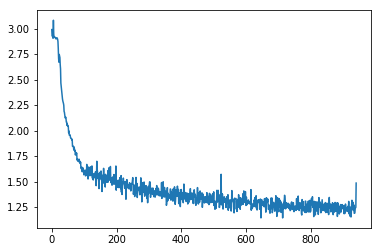

In [0]:
pyplot.plot(hist_loss)
pyplot.show()

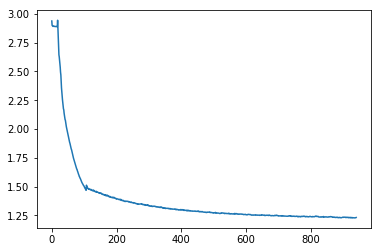

In [0]:
pyplot.plot(hist_val_loss)
pyplot.show()

In [0]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        # apply softmax to get p probabilities for the likely next character giving x
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        
        # keep probability to use later
        prob = p.numpy().squeeze()
        char_index = np.argmax(prob)
        char_pred = net.int2char[char_index]
        prob_pred = prob[char_index]
        
#         # get top characters
#         # considering the k most probable characters with topk method
#         if top_k is None:
#             top_ch = np.arange(len(net.chars))
#         else:
#             p, top_ch = p.topk(top_k)
#             top_ch = top_ch.numpy().squeeze()
        
        
#         # select the likely next character with some element of randomness
#         p = p.numpy().squeeze()
#         char = np.random.choice(top_ch, p=p/p.sum())
        
#         # return the encoded value of the predicted char and the hidden state
#        return net.int2char[char], h, prob
        return char_pred, h, prob_pred

In [0]:
t1 = time.time()
prime = 'but to speak seriou' # But to speak seriously
# print('length of prime = {}'.format(len(prime)))

chars = [ch for ch in prime]
h = net.init_hidden(1)
for ch in prime:
  char, h, prob = predict(net, ch, h)
  print("ch = {}, char = {}, prob = {}".format(ch, char, prob))

print("time taken to predict: {}".format(time.time()-t1))
  
  

ch = b, char = e, prob = 0.30611371994018555
ch = u, char = l, prob = 0.5654222965240479
ch = t, char =  , prob = 0.5635764002799988
ch =  , char = a, prob = 0.1304537057876587
ch = t, char = h, prob = 0.6685751080513
ch = o, char =  , prob = 0.925091028213501
ch =  , char = t, prob = 0.14843431115150452
ch = s, char = a, prob = 0.27939751744270325
ch = p, char = e, prob = 0.5872915387153625
ch = e, char = a, prob = 0.9448623657226562
ch = a, char = k, prob = 0.9943780303001404
ch = k, char =  , prob = 0.919374942779541
ch =  , char = o, prob = 0.5279476046562195
ch = s, char = o, prob = 0.3095758259296417
ch = e, char = e, prob = 0.3643374443054199
ch = r, char = v, prob = 0.669789731502533
ch = i, char = o, prob = 0.886081337928772
ch = o, char = u, prob = 0.9984220266342163
ch = u, char = s, prob = 0.9993937015533447
time taken to predict: 0.02683401107788086


In [0]:
0.015*1.4*1000000/60/60

5.833333333333332

In [0]:
# def sample(net, size, prime='ba', top_k=None):
        
#     if(train_on_gpu):
#         net.cuda()
#     else:
#         net.cpu()
    
#     net.eval() # eval mode
    
#     # First off, run through the prime characters
#     chars = [ch for ch in prime]
#     h = net.init_hidden(1)
#     for ch in prime:
#         char, h = predict(net, ch, h, top_k=top_k)
#         print("ch = {}, char = {}".format(ch, char))

#     chars.append(char)
    
#     # Now pass in the previous character and get a new one
#     for ii in range(size):
#         char, h = predict(net, chars[-1], h, top_k=top_k)
#         chars.append(char)
#         print("chars[-1] = {}, char = {}".format(chars[-1], char))

#     return ''.join(chars)

In [0]:
# Stopped here!!!

In [0]:
model_1 = 'rnn_20_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_dante, 'wb') as f:
    torch.save(checkpoint, f)

In [0]:
from graphviz import Digraph
import networkx as nx
from matplotlib import pyplot
import random
import pandas as pd
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model
from keras import metrics
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import tensorflow as tf
import numpy as np
import sys
import io
from keras import models 
from keras import layers

# TODO: chnage 256 to a smaller number - check accuracy plots + different epochs
# TODO: hidden state calculation should be faster - can be enabled based on the need 
# or disabled if only properties of Y

Using TensorFlow backend.


In [0]:
# train model on nietszche on the same parameters as marisa
# 

In [0]:
#####################################################################
#    Parameters
#####################################################################

# input and output
sizeX = 3
sizeY = sizeX   # next character prediction


# text information
alphabet = ['c', 'a', 't', 'e', ' ']
sizeAlphabet = len(alphabet)

# human words generated by scramble game
human_words = ['cate',  'tace', 'ace',  'act',  'ate',  'cat', 'eat', 'eta', 
               'tae', 'tea', 'ae', 'at', 'et', 'ta']
n_words_in_corpus = 100000


print("Alphabet used: {}".format(alphabet))
print("Human words count : {}".format(len(human_words)))

Alphabet used: ['c', 'a', 't', 'e', ' ']
Human words count : 14


In [0]:
#####################################################################
#    Create corpus to train a model
#####################################################################
text = ''
for i in range(0, n_words_in_corpus):
    if i % 10000 == 0:
      print("i = {}".format(i))
      
    j = int(random.uniform(0, len(human_words)))
    text = text + ' ' + human_words[j]

file = open('cat_' + str(n_words_in_corpus) + '.txt', 'w')
file.write(text)
file.close()

_ = pd.Series(text.split(' '))
print("Words distribution: {}".format(_.value_counts()))

i = 0
i = 10000
i = 20000
i = 30000
i = 40000
i = 50000
i = 60000
i = 70000
i = 80000
i = 90000
Words distribution: eta     7332
tea     7254
ace     7241
ate     7234
tace    7160
ta      7158
act     7136
cat     7132
et      7122
eat     7120
at      7061
tae     7033
ae      7014
cate    7003
           1
dtype: int64


In [0]:
#####################################################################
#    Train model
#####################################################################
def sentence_to_code(sentence, char_indices, maxlen, sizeAlphabet):
  x = np.zeros((1, maxlen, sizeAlphabet))
  for t, char in enumerate(sentence):
      x[0, t, char_indices[char]] = 1.0
  return x

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 3
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print("Chars to indices encoding: {}".format(char_indices))

# Sequential API
print('Build model...')
model = Sequential()
lstm_hunits = 256  # TODO: tune this parameter
model.add(LSTM(lstm_hunits, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[metrics.mae, metrics.categorical_accuracy])
plot_model(model, to_file='multilayer_perceptron_graph.png')

total chars: 5
nb sequences: 128602
Vectorization...


W0726 21:24:49.996254 140106769180544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 21:24:50.034121 140106769180544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 21:24:50.041134 140106769180544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Chars to indices encoding: {' ': 0, 'a': 1, 'c': 2, 'e': 3, 't': 4}
Build model...


W0726 21:24:50.497117 140106769180544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0726 21:24:50.507740 140106769180544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               268288    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 269,573
Trainable params: 269,573
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("x size = {}".format(x.shape))
print("LSTM Layer Parameters: {}".format(4*(lstm_hunits*lstm_hunits + lstm_hunits*sizeAlphabet + lstm_hunits))) # 4*(256*256 + 5*256 + 256*1) 
print("Dense Layer Parameters: {}".format(lstm_hunits*sizeAlphabet + sizeAlphabet))  # dense 5*256 + 5
print("y size = {}".format(x.shape))

x size = (128602, 3, 5)
LSTM Layer Parameters: 268288
Dense Layer Parameters: 1285
y size = (128602, 3, 5)


In [0]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# history = funcmodel1.fit(x, [y,0.1*np.ones((128570, len(chars))), 0.1*np.ones((128570, len(chars)))], # [y, np.zeros((128570, len(chars))), np.zeros((128570, len(chars)))],#,np.zeros((128570, len(chars))),np.zeros((128570, len(chars)))],
history = model.fit(x, y,          
          batch_size=128,
          epochs=10,
          callbacks=[print_callback])

W0726 21:24:50.901676 140106769180544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0726 21:24:51.457036 140106769180544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
128602/128602 [==============================] - 13s 98us/step - loss: 0.7190 - mean_absolute_error: 0.1684 - categorical_accuracy: 0.6222

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "te "
te act tace act ta at at tace ta at at ate at tace at ate ace ace tace at at at ate ate ate et at at at act at ace ta ate at at at at tace ta act at tace at act eta act eta tae at ta act ate act tace at act act ate at ae at ta ace at ate ta ta ta at at eta at ate act act at at act ate at at ate at at ate act act at act at at ate at ta at at tace et at ace at ta at at at ta at at at ace at tace act ac
----- diversity: 0.5
----- Generating with seed: "te "
te tae eta tae tace et tace act tae ta ta at eta cat ae ate ate ta at cate tace eta eta at eta ate cat ate at ae act at tae et act et act at ate tea tae ace cat ate ate at ate ae ae act eat ae ta cate ate ta eta tace act ate eta eat cat cate ae ta act et tae ta ace tace ate ta tace at tace ate tea

In [0]:
for layer in model.layers:
  print(str(layer))
  if "LSTM" in str(layer):
    weightLSTM = layer.get_weights()
    print(weightLSTM)

[array([[ 0.16180338, -0.44682   , -0.9238099 , ..., -0.9318583 ,
        -0.80301833, -0.16427341],
       [-1.6078061 , -0.19245127, -0.6052501 , ..., -0.7866689 ,
         1.4994727 , -0.52670336],
       [-1.5039694 , -0.5746567 , -0.7674525 , ..., -0.086352  ,
        -0.44441077, -0.7339176 ],
       [-0.9748969 , -0.52643925, -0.7783226 , ..., -0.77676314,
         0.29341778, -0.9405036 ],
       [-1.7909539 , -0.27107647, -0.53002477, ..., -0.804148  ,
        -4.177213  , -0.9848498 ]], dtype=float32), array([[-0.72240305,  0.42264906, -0.40500495, ..., -0.43208626,
        -0.27036294, -0.54650664],
       [-0.01617666,  0.33695662, -0.17524286, ...,  0.24705096,
        -0.83379006,  0.32780185],
       [-0.1772233 ,  0.4163966 , -0.11492799, ...,  0.38892135,
        -0.8148125 , -0.4048778 ],
       ...,
       [ 0.12191802,  0.0403789 ,  0.5460233 , ..., -0.0604958 ,
        -0.96460193, -0.18222257],
       [-0.26894945,  0.03734601,  0.27506408, ..., -0.01556842,
     

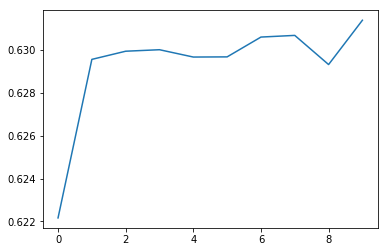

In [0]:
# plot metrics
pyplot.plot(history.history['categorical_accuracy'])
pyplot.show()

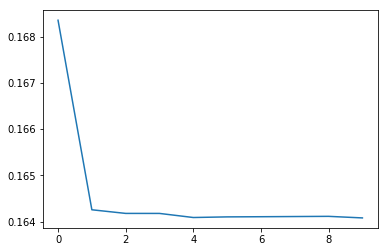

In [0]:
# plot metrics
pyplot.plot(history.history['mean_absolute_error'])
pyplot.show()

In [0]:
#####################################################################
# Validate that models predicts well
#####################################################################
generated = ''
sentence = ' ca'
generated += sentence
print('----- Generating with seed: "' + sentence + '"')

x_pred = np.zeros((1, maxlen, len(chars)))
for t, char in enumerate(sentence):
    x_pred[0, t, char_indices[char]] = 1.

preds = model.predict(x_pred, verbose=0)[0]
print("preds =", preds)
next_index = sample(preds, 0.001)
next_char = indices_char[next_index]

sys.stdout.write("next_char = {} \n".format(next_char))


----- Generating with seed: " ca"
preds = [1.5054302e-11 3.5823709e-13 5.0906341e-09 2.0427080e-09 1.0000000e+00]
next_char = t 


In [0]:
#####################################################################
#    Save model
#####################################################################
model.save('model_train{}_alphabet{}_x{}.h5'.format(n_words_in_corpus, sizeAlphabet, sizeX))

In [0]:
#####################################################################
#    Create StateTransition System from RNN
#####################################################################

# I. Create Graph Structure (using only metadata of the network)
#------------------------------------------------------------------------------

# G is the graph constructed from RNN Inputs
G = nx.balanced_tree(r=sizeAlphabet, h=sizeX)
f = Digraph('balanced_tree', filename='balanced_'+str(sizeX)+'_'+str(sizeAlphabet)+'.gv')
f.attr(rankdir='LR', size='8,5')

for b_node in G.nodes:
    f.node("S"+str(b_node), H="", Y="")

for i, b_edge in enumerate(G.edges):
    label = alphabet[i%sizeAlphabet]
    f.edge("S"+str(b_edge[0]), "S"+str(b_edge[1]), label)
    
# II. Create Attributes Empty and assign to the nodes
#------------------------------------------------------------------------------

labels = {}
rnn_states = {}

r = sizeAlphabet
h = sizeX

# root:
state_placeholder = np.array([])
rnn_states[0] = state_placeholder  # state will contain rnn H and Y of the model
next_node_id = 1

for level in range(1,h+1):
  print("Tree level:", level)  
  elemnts_count = pow(r,level)
  print("elemnts_count = ", elemnts_count)
  
  print("Nodes btw :", next_node_id, " and ", next_node_id + elemnts_count)
  for node_id in range(next_node_id,  next_node_id + elemnts_count): 
    rnn_states[node_id] = state_placeholder
    labels[node_id] = alphabet[node_id%sizeAlphabet]
  next_node_id = node_id+1
  print("next_node_id = ", next_node_id)

nx.set_node_attributes(G, labels, 'label')
nx.set_node_attributes(G, rnn_states, 'rnn_state')

# III. Get x per node
#------------------------------------------------------------------------------

x_val = {}
above_labels = {}

for node_id in G.nodes:
  node = G.nodes[node_id]
  print("node_id=",node_id, " node = ",node)
  shortest_path = nx.shortest_path(G, source=0, target=node_id)
  above_labels_str = ""
  for j in shortest_path[1:]:
    above_labels_str = above_labels_str + G.nodes[j]['label']
  print("above_labels_str = ", above_labels_str)
  
  
  if 'label' in node.keys():
    label = node['label']
    print("label = ", label)
    above_labels[node_id] = above_labels_str
    
    if len(above_labels_str) <= maxlen:
      x_val[node_id] = sentence_to_code(above_labels_str, char_indices, maxlen, sizeAlphabet)
    else:
      x_val[node_id] =np.array([])
nx.set_node_attributes(G, above_labels, 'above_labels')
nx.set_node_attributes(G, x_val, 'x_val')

# IV. Get y per node
#------------------------------------------------------------------------------
y_val = {}
for node in G.nodes():
  if 'x_val' in  G.nodes[node].keys():
    x_val_node = G.nodes[node]['x_val']
    y_val_node = model.predict(x_val_node, verbose=0)[0]
    y_val[node] = y_val_node
nx.set_node_attributes(G, y_val, 'y_val')

# IV. Calculate hidden states per node
#------------------------------------------------------------------------------
for layer in model.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
warr,uarr, barr = weightLSTM
warr.shape,uarr.shape,barr.shape


def get_hidden_states_keras(model, xs, sizeX, sizeAlphabet, lstm_hunits):
  batch_size = 1
  len_ts = sizeX
  nfeature = sizeAlphabet
  inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                         name="input")  
  rnn,s,c = layers.LSTM(lstm_hunits, 
                           return_sequences=True,
                           stateful=False,
                           return_state=True,
                           name="RNN")(inp)
  states = models.Model(inputs=[inp],outputs=[s,c, rnn])
  for layer in states.layers:
      for layer1 in model.layers:
          if layer.name == layer1.name:
              layer.set_weights(layer1.get_weights())
  h_t_keras, c_t_keras, rnn = states.predict(xs.reshape(1,len_ts,5))  
  return (h_t_keras, c_t_keras)


# # Example:

# xs = np.array([[[0., 0., 0., 0., 1.],
#         [1., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0.]]])
# tmp = get_hidden_states_keras(model, xs, sizeX, sizeAlphabet, lstm_hunits)
# print("tmp ={}".format(tmp))



h_val = {}
for node in G.nodes():
  if 'x_val' in  G.nodes[node].keys():
    x_val_node = G.nodes[node]['x_val']
    h_val_node = get_hidden_states_keras(model, x_val_node, sizeX, sizeAlphabet, lstm_hunits)
    h_val[node] = h_val_node
    
nx.set_node_attributes(G, h_val, 'h_val')

Tree level: 1
elemnts_count =  5
Nodes btw : 1  and  6
next_node_id =  6
Tree level: 2
elemnts_count =  25
Nodes btw : 6  and  31
next_node_id =  31
Tree level: 3
elemnts_count =  125
Nodes btw : 31  and  156
next_node_id =  156
node_id= 0  node =  {'rnn_state': array([], dtype=float64)}
above_labels_str =  
node_id= 1  node =  {'label': 'a', 'rnn_state': array([], dtype=float64)}
above_labels_str =  a
label =  a
node_id= 2  node =  {'label': 't', 'rnn_state': array([], dtype=float64)}
above_labels_str =  t
label =  t
node_id= 3  node =  {'label': 'e', 'rnn_state': array([], dtype=float64)}
above_labels_str =  e
label =  e
node_id= 4  node =  {'label': ' ', 'rnn_state': array([], dtype=float64)}
above_labels_str =   
label =   
node_id= 5  node =  {'label': 'c', 'rnn_state': array([], dtype=float64)}
above_labels_str =  c
label =  c
node_id= 6  node =  {'label': 'a', 'rnn_state': array([], dtype=float64)}
above_labels_str =  aa
label =  a
node_id= 7  node =  {'label': 't', 'rnn_state':

In [0]:
#####################################################################
#    Ground truth property satisfaction
#####################################################################
total_combinations = len(G.nodes()) # total nodes
n_satisfy = 0
# calculate Property rate over ground truth Graph
for node in G.nodes():
  if 'y_val' in  G.nodes[node].keys():
    y_val_node = G.nodes[node]['y_val']
    if any(y_val_node>0.8):
      n_satisfy = n_satisfy + 1
gt_satisfy = n_satisfy/total_combinations
print("Ground truth property satisfaction rate:{}".format(gt_satisfy)) 

Ground truth property satisfaction rate:0.4807692307692308


In [0]:
####################################################
#  TensorSMC
####################################################
alpha = 1 
beta = 1 

smc_satisfy_rates = []
smc_ro_estimates = []
smc_nu_estimates = []
increasing_samples  = range(1, total_combinations, 5)

for j in increasing_samples:
  n_trajectories = 0   # number trajectories drawn so far
  n_satisfy = 0     # number of trajectories satisfying property so far

  for n_trajectories in range(0,j+1):
    index_rand = random.randrange(total_combinations)
    if 'y_val' in  G.nodes[index_rand].keys():
      y_val_node = G.nodes[index_rand]['y_val']
      if any(y_val_node>0.8):
        n_satisfy = n_satisfy + 1
  print("n_satisfy={}, n_trajectories={}".format(n_satisfy, n_trajectories))
  print("SMC property satisfaction rate:{}".format(n_satisfy/n_trajectories)) 
  ro = (n_satisfy + alpha)/(n_trajectories + alpha + beta)
  nu = np.sqrt(((alpha + n_satisfy)*(n_trajectories - n_satisfy + beta)) / (pow((alpha + n_trajectories + beta),2)*(alpha + n_trajectories + beta + 1)))
  print("Estiamted property satisfaction:{} +/- {}".format(ro, nu)) 
  smc_satisfy_rates.append(n_satisfy/n_trajectories)
  smc_ro_estimates.append(ro)
  smc_nu_estimates.append(nu)



n_satisfy=0, n_trajectories=1
SMC property satisfaction rate:0.0
Estiamted property satisfaction:0.3333333333333333 +/- 0.23570226039551584
n_satisfy=3, n_trajectories=6
SMC property satisfaction rate:0.5
Estiamted property satisfaction:0.5 +/- 0.16666666666666666
n_satisfy=5, n_trajectories=11
SMC property satisfaction rate:0.45454545454545453
Estiamted property satisfaction:0.46153846153846156 +/- 0.13323467750529824
n_satisfy=8, n_trajectories=16
SMC property satisfaction rate:0.5
Estiamted property satisfaction:0.5 +/- 0.11470786693528089
n_satisfy=10, n_trajectories=21
SMC property satisfaction rate:0.47619047619047616
Estiamted property satisfaction:0.4782608695652174 +/- 0.10196555999616151
n_satisfy=14, n_trajectories=26
SMC property satisfaction rate:0.5384615384615384
Estiamted property satisfaction:0.5357142857142857 +/- 0.09261050990404297
n_satisfy=15, n_trajectories=31
SMC property satisfaction rate:0.4838709677419355
Estiamted property satisfaction:0.48484848484848486 +/

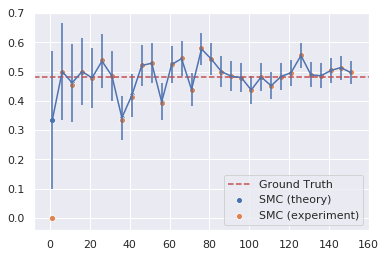

In [0]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(x=increasing_samples, y=smc_ro_estimates)
ax.errorbar(increasing_samples, smc_ro_estimates, yerr=smc_nu_estimates)
sns.scatterplot(x=increasing_samples, y=smc_satisfy_rates, ax = ax)
ax.axhline(gt_satisfy, ls='--', color='r')
ax.legend(labels=['Ground Truth', 'SMC (theory)', 'SMC (experiment)'])

In [0]:
f